# Tyre Degredation in F1 2025
- In this notebook we will hypothesise and thereby confirm the trends in tyre degredation of F1 teams and drivers across raceweekend throughout a season.
- The initial analysis will feature the most abrasive or (/and) tyre energy heavy tracks on the calendar:
    - Jeddah, Saudi Arabia `(focus of this notebook)`
    - Sakhir, Bahrain
    - Silverstone, United Kingdom
    - Catalunya, Spain
    - Austin, United States of America

In [234]:
import fastf1

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

### Notebook Configs

In [235]:
DATAPATH = Path("data")
DATAPATH.mkdir(exist_ok=True)

### Loading the Event

In [236]:
jeddah_2025 = fastf1.get_event(
    year=2025,
    gp="saudiarabia"
)
jeddah_2025

RoundNumber                                                    5
Country                                             Saudi Arabia
Location                                                  Jeddah
OfficialEventName    FORMULA 1 STC SAUDI ARABIAN GRAND PRIX 2025
EventDate                                    2025-04-20 00:00:00
EventName                               Saudi Arabian Grand Prix
EventFormat                                         conventional
Session1                                              Practice 1
Session1Date                           2025-04-18 16:30:00+03:00
Session1DateUtc                              2025-04-18 13:30:00
Session2                                              Practice 2
Session2Date                           2025-04-18 20:00:00+03:00
Session2DateUtc                              2025-04-18 17:00:00
Session3                                              Practice 3
Session3Date                           2025-04-19 16:30:00+03:00
Session3DateUtc          

### Loading the Race Session

In [237]:
# Accessing the Race Session
jeddah_race = jeddah_2025.get_race()

# Loading all the data from the API
jeddah_race.load(
    laps=True,
    telemetry=False,
    weather=True,
    messages=True
)

core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '1', '16', '4', '63', '12', '44', '55', '23', '6', '14', '30', '87', '31', '27', '18', '7', '5', '22', '10']


In [238]:
race_laps = jeddah_race.laps

# Dropping the unnecessary cols
drop_cols = [
    "Sector1SessionTime", "Sector2SessionTime", "Sector3SessionTime", 
    "LapStartTime", "LapStartDate", "FastF1Generated", "IsAccurate", "DeletedReason"
]
race_laps = race_laps.drop(drop_cols, axis=1)
race_laps.head()

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,SpeedFL,SpeedST,IsPersonalBest,Compound,TyreLife,FreshTyre,Team,TrackStatus,Position,Deleted
0,0 days 00:59:02.420000,PIA,81,0 days 00:02:04.986000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:29.518000,...,163.0,145.0,False,MEDIUM,1.0,True,McLaren,124,2.0,False
1,0 days 01:01:46.365000,PIA,81,NaT,2.0,1.0,NaT,NaT,0 days 00:01:08.447000,0 days 00:00:49.209000,...,269.0,226.0,False,MEDIUM,2.0,True,McLaren,4,2.0,False
2,0 days 01:04:41.597000,PIA,81,NaT,3.0,1.0,NaT,NaT,0 days 00:00:56.071000,0 days 00:00:46.270000,...,295.0,82.0,False,MEDIUM,3.0,True,McLaren,41,3.0,False
3,0 days 01:06:15.844000,PIA,81,0 days 00:01:34.247000,4.0,1.0,NaT,NaT,0 days 00:00:34.829000,0 days 00:00:29.607000,...,294.0,307.0,True,MEDIUM,4.0,True,McLaren,1,2.0,False
4,0 days 01:07:49.262000,PIA,81,0 days 00:01:33.418000,5.0,1.0,NaT,NaT,0 days 00:00:34.522000,0 days 00:00:29.411000,...,304.0,325.0,True,MEDIUM,5.0,True,McLaren,1,2.0,False


In [239]:
# Changing the Lap and Sector Times from TimeDelta to Seconds
lap_cols = ["LapTime", "PitOutTime", "PitInTime", "Sector1Time", "Sector2Time", "Sector3Time"]
for col in lap_cols:
    race_laps[col] = race_laps[col].apply(lambda x: x.total_seconds())

# Revised DataFrame
race_laps.head()

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,SpeedFL,SpeedST,IsPersonalBest,Compound,TyreLife,FreshTyre,Team,TrackStatus,Position,Deleted
0,0 days 00:59:02.420000,PIA,81,124.986,1.0,1.0,NaN,NaN,NaN,29.518,...,163.0,145.0,False,MEDIUM,1.0,True,McLaren,124,2.0,False
1,0 days 01:01:46.365000,PIA,81,NaN,2.0,1.0,NaN,NaN,68.447,49.209,...,269.0,226.0,False,MEDIUM,2.0,True,McLaren,4,2.0,False
2,0 days 01:04:41.597000,PIA,81,NaN,3.0,1.0,NaN,NaN,56.071,46.270,...,295.0,82.0,False,MEDIUM,3.0,True,McLaren,41,3.0,False
3,0 days 01:06:15.844000,PIA,81,94.247,4.0,1.0,NaN,NaN,34.829,29.607,...,294.0,307.0,True,MEDIUM,4.0,True,McLaren,1,2.0,False
4,0 days 01:07:49.262000,PIA,81,93.418,5.0,1.0,NaN,NaN,34.522,29.411,...,304.0,325.0,True,MEDIUM,5.0,True,McLaren,1,2.0,False


### Analysing the Tyre Degredation

**Key Assumptions Made**
- Due to the lack of hybrid energy and ICE deployment data I have ignored the contribution of the hybrid in pace calculation and enforced a weighted constant for ICE contribution as per the previous regulations (2022 - 2025).
- While car telemetry data is available, it wasn't available for the race session and hence the fuel burn calculation is laid out for the worst case scenario i.e, the max fuel-flow is being utilsed every second of the lap. Thus, every lap in this racing world is hence is near push lap which punishes bad tyre degredation further.
- I have chosen to focus on the top 5 by calculating the mean position of a driver throughout the race (lower is better) since the front of the pack is in resonably clean air and in the contention for a race win leaving nothing in the cockpit. 

In [240]:
# Key Parameters to utilise for pure pace of the car during the race

# Maximum Fuel Load permissible for the car (110 KG)
max_fuel_load = 105  # Flexiblity for race lap time

# Fuel Burn kg - per/second (27.8g per/sec)
fuel_burn_rate = 27.8 * 1e-3

# Fuel Load to Weight Constant (10Kg => 0.3sec)
fuel_load_constant = 0.3 * 1e-1

# Internal Combustion Contribution through a Lap
ice_const = 0.8

In [241]:
# Copy of the original laps
quick_race_laps = race_laps.pick_quicklaps().copy()

# Fuel Burnt in the Lap as a Cumulative Sum
quick_race_laps.insert(loc=len(quick_race_laps.columns), column="LapFuelBurnt", value=0)
quick_race_laps["LapFuelBurnt"] = quick_race_laps["LapTime"] * fuel_burn_rate * ice_const
quick_race_laps["LapFuelBurnt"] = quick_race_laps[["LapFuelBurnt", "Driver"]].groupby("Driver").cumsum()

# Fuel Aware Laptime
fuel_weight_lost_wrt_time = (max_fuel_load - quick_race_laps["LapFuelBurnt"]) * fuel_load_constant
quick_race_laps["FuelAwareLapTime"] = quick_race_laps["LapTime"] - fuel_weight_lost_wrt_time

quick_race_laps

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,IsPersonalBest,Compound,TyreLife,FreshTyre,Team,TrackStatus,Position,Deleted,LapFuelBurnt,FuelAwareLapTime
3,0 days 01:06:15.844000,PIA,81,94.247,4.0,1.0,NaN,NaN,34.829,29.607,...,True,MEDIUM,4.0,True,McLaren,1,2.0,False,2.096053,91.159882
4,0 days 01:07:49.262000,PIA,81,93.418,5.0,1.0,NaN,NaN,34.522,29.411,...,True,MEDIUM,5.0,True,McLaren,1,2.0,False,4.173670,90.393210
5,0 days 01:09:23.179000,PIA,81,93.917,6.0,1.0,NaN,NaN,34.783,29.453,...,False,MEDIUM,6.0,True,McLaren,1,2.0,False,6.262384,90.954872
6,0 days 01:10:56.702000,PIA,81,93.523,7.0,1.0,NaN,NaN,34.373,29.422,...,False,MEDIUM,7.0,True,McLaren,1,2.0,False,8.342335,90.623270
7,0 days 01:12:30.595000,PIA,81,93.893,8.0,1.0,NaN,NaN,34.442,29.510,...,False,MEDIUM,8.0,True,McLaren,1,2.0,False,10.430516,91.055915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889,0 days 02:08:42.756000,BOR,5,95.355,43.0,2.0,NaN,NaN,35.373,29.923,...,False,HARD,42.0,True,Kick Sauber,1,16.0,False,83.120465,94.698614
890,0 days 02:10:17.581000,BOR,5,94.825,44.0,2.0,NaN,NaN,34.919,29.848,...,False,HARD,43.0,True,Kick Sauber,1,16.0,False,85.229373,94.231881
891,0 days 02:11:53.098000,BOR,5,95.517,45.0,2.0,NaN,NaN,35.133,30.055,...,False,HARD,44.0,True,Kick Sauber,1,16.0,False,87.353672,94.987610
894,0 days 02:16:47.556000,BOR,5,97.130,48.0,2.0,NaN,NaN,36.846,30.120,...,False,HARD,47.0,True,Kick Sauber,1,17.0,False,89.513843,96.665415


In [242]:
# Verifying for non-negative fuel-load duing the calculation
quick_race_laps[["LapFuelBurnt", "Driver"]].groupby("Driver").last()

,LapFuelBurnt
Driver,
ALB,96.823730
ALO,92.675859
ANT,93.984972
BEA,94.893743
BOR,91.642166
DOO,95.708372
HAD,96.889427
HAM,96.272379
HUL,93.291440


In [243]:
# Filtering the laps down to the top 5 contenders for easier analysis

# Grouping the drivers to mean position and count for each of the actual positions
driver_positions = quick_race_laps.groupby("Driver")["Position"].agg(["mean", "count"])

# Finding the drivers consistently at the front of the pack
driver_positions["PercentageAtFront"] = driver_positions["count"] / driver_positions["mean"]

# Sorting the drivers by the Percentage at Front
driver_positions = driver_positions.sort_values(by="PercentageAtFront", ascending=False)

driver_positions

,mean,count,PercentageAtFront
Driver,,,
PIA,1.847826,46,24.894118
VER,2.021739,46,22.752688
LEC,3.195652,46,14.394558
RUS,3.978261,46,11.562842
NOR,4.369565,46,10.527363
ANT,6.000000,45,7.500000
HAM,6.804348,46,6.760383
SAI,8.521739,46,5.397959
HAD,9.000000,46,5.111111


In [244]:
# Filtering the race laps to the top 5 drivers for degradation analysis
filtered_quick_race_laps = quick_race_laps.pick_drivers(driver_positions.index[:5]).copy()
filtered_quick_race_laps

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,IsPersonalBest,Compound,TyreLife,FreshTyre,Team,TrackStatus,Position,Deleted,LapFuelBurnt,FuelAwareLapTime
3,0 days 01:06:15.844000,PIA,81,94.247,4.0,1.0,NaN,NaN,34.829,29.607,...,True,MEDIUM,4.0,True,McLaren,1,2.0,False,2.096053,91.159882
4,0 days 01:07:49.262000,PIA,81,93.418,5.0,1.0,NaN,NaN,34.522,29.411,...,True,MEDIUM,5.0,True,McLaren,1,2.0,False,4.173670,90.393210
5,0 days 01:09:23.179000,PIA,81,93.917,6.0,1.0,NaN,NaN,34.783,29.453,...,False,MEDIUM,6.0,True,McLaren,1,2.0,False,6.262384,90.954872
6,0 days 01:10:56.702000,PIA,81,93.523,7.0,1.0,NaN,NaN,34.373,29.422,...,False,MEDIUM,7.0,True,McLaren,1,2.0,False,8.342335,90.623270
7,0 days 01:12:30.595000,PIA,81,93.893,8.0,1.0,NaN,NaN,34.442,29.510,...,False,MEDIUM,8.0,True,McLaren,1,2.0,False,10.430516,91.055915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0 days 02:12:15.681000,RUS,63,93.905,46.0,2.0,NaN,NaN,34.678,29.326,...,False,HARD,26.0,True,Mercedes,1,5.0,False,87.707465,93.386224
246,0 days 02:13:49.632000,RUS,63,93.951,47.0,2.0,NaN,NaN,34.588,29.550,...,False,HARD,27.0,True,Mercedes,1,5.0,False,89.796936,93.494908
247,0 days 02:15:23.593000,RUS,63,93.961,48.0,2.0,NaN,NaN,34.793,29.442,...,False,HARD,28.0,True,Mercedes,1,5.0,False,91.886628,93.567599
248,0 days 02:16:57.319000,RUS,63,93.726,49.0,2.0,NaN,NaN,34.626,29.423,...,False,HARD,29.0,True,Mercedes,1,5.0,False,93.971095,93.395133


In [245]:
# Combining the Driver Identifier and Compound for easier Viz and Analysis
filtered_quick_race_laps["DriverCompoundForStint"] = filtered_quick_race_laps["Driver"].str.cat(others=filtered_quick_race_laps["Compound"], sep=" - ")
filtered_quick_race_laps

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,Compound,TyreLife,FreshTyre,Team,TrackStatus,Position,Deleted,LapFuelBurnt,FuelAwareLapTime,DriverCompoundForStint
3,0 days 01:06:15.844000,PIA,81,94.247,4.0,1.0,NaN,NaN,34.829,29.607,...,MEDIUM,4.0,True,McLaren,1,2.0,False,2.096053,91.159882,PIA - MEDIUM
4,0 days 01:07:49.262000,PIA,81,93.418,5.0,1.0,NaN,NaN,34.522,29.411,...,MEDIUM,5.0,True,McLaren,1,2.0,False,4.173670,90.393210,PIA - MEDIUM
5,0 days 01:09:23.179000,PIA,81,93.917,6.0,1.0,NaN,NaN,34.783,29.453,...,MEDIUM,6.0,True,McLaren,1,2.0,False,6.262384,90.954872,PIA - MEDIUM
6,0 days 01:10:56.702000,PIA,81,93.523,7.0,1.0,NaN,NaN,34.373,29.422,...,MEDIUM,7.0,True,McLaren,1,2.0,False,8.342335,90.623270,PIA - MEDIUM
7,0 days 01:12:30.595000,PIA,81,93.893,8.0,1.0,NaN,NaN,34.442,29.510,...,MEDIUM,8.0,True,McLaren,1,2.0,False,10.430516,91.055915,PIA - MEDIUM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0 days 02:12:15.681000,RUS,63,93.905,46.0,2.0,NaN,NaN,34.678,29.326,...,HARD,26.0,True,Mercedes,1,5.0,False,87.707465,93.386224,RUS - HARD
246,0 days 02:13:49.632000,RUS,63,93.951,47.0,2.0,NaN,NaN,34.588,29.550,...,HARD,27.0,True,Mercedes,1,5.0,False,89.796936,93.494908,RUS - HARD
247,0 days 02:15:23.593000,RUS,63,93.961,48.0,2.0,NaN,NaN,34.793,29.442,...,HARD,28.0,True,Mercedes,1,5.0,False,91.886628,93.567599,RUS - HARD
248,0 days 02:16:57.319000,RUS,63,93.726,49.0,2.0,NaN,NaN,34.626,29.423,...,HARD,29.0,True,Mercedes,1,5.0,False,93.971095,93.395133,RUS - HARD


### Visualisations

**Tyre Performance by Stint during the Race (for Front Runners)**

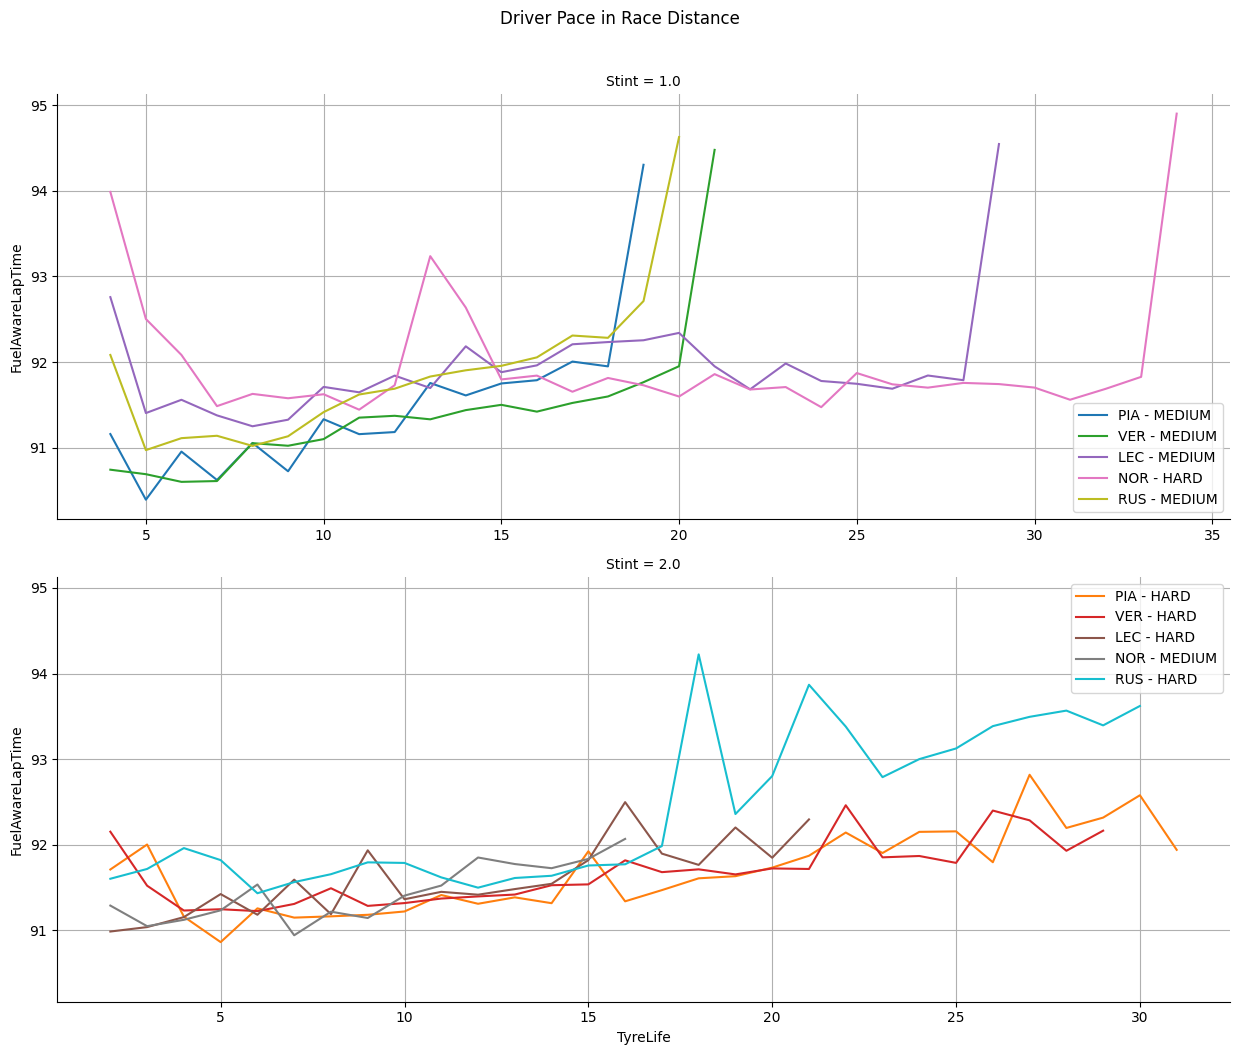

In [246]:
line_grid = sns.FacetGrid(
    data=filtered_quick_race_laps,
    row="Stint",
    hue="DriverCompoundForStint",
    height=5,
    aspect=2.5,
    sharex=False
)

line_grid.map_dataframe(
    sns.lineplot,
    x="TyreLife",
    y="FuelAwareLapTime"
)

for ax in line_grid.axes.flatten():
    ax.legend()
    ax.grid()

line_grid.figure.suptitle("Driver Pace in Race Distance", y=1.05)
plt.show()

**Inference**
- Stint - 1:
*Note: Leclerc needs to be analysed further as he went long on a medium with good pace.*
    - `Verstappen`: by far has the best tyre deg on the Mediums of the top 5 where 3 other drivers including himself were on the same tyre.
    - `Piastri` and `Leclerc`: Piastri on similar strategy as Max had the second best tyre deg, while Leclerc also had amazing tyre deg considering he went atleast 8 laps longer that max on the same tyre.
    - `Russel`: Had the worst tyre deg of the medium strategy bunch having pushed harder / poor tyre management / dirty air earlier in the stint.
    - `Norris`: On the opposite strategy went longer on the hards which took their time to get into the tyre window thus the average time lost earlier in the stint is massive since the laptime are slower that Russel. Further might have been a mistake lap 13 identified by the spike however, hards have good durability so he was able to pull it back later in the stint by lapping the best pace of the mediums for 20 laps before stint 2.

- Stint - 2:
*Note: Overall there doesn't seem to be much distinction between the mediums (NOR) and hards of the rest during the second stint could be attributed to better track evolution and provisionally the drivers on hards bringing the tyre's to their operating window fast and well.*
    - `Verstappen` and `Piastri`: Both drivers have identical pace throughout the stint however, Piastri seems to have pushed / reached the window earlier since he pitted first during the first stint. However, Piastri pace is spiky during the stint prospectivly overtakes (from traffic or track position). Verstappen has a smoother curve indicating sustained pace for longer with spikes towards the end of the stint, provisonally overtakes (from traffic or track position).
    - `Leclerc`: Having pitted later he had a stonking out lap to push the hards to the operating window quicker than others since he had lesser distance to cover on them. He has spikes which should definitely be overtakes for position due to the strategy he was on but the pace is really good inline with VER and PIA.
    - `Russel`: Seems to have the worst pace on the hard both getting them into the window and then utilising the grip later into the stint with maybe mistakes or traffic later in the stint (large spikes and increased slope towards the end of the stint).
    - `Norris`: On the opposite startegy go into the operating window quickly too but LEC was still better. Norris was mostly inline in pace with the hard runners with minor spikes for overtaking traffic or gaining track position with ease. Having pitted last in the first stint he was in good pace with the Medium front runners but the tyre gains were marginal.


**Quantifying the Tyre Degredation by Stint (for the Front Runners)**

In [247]:
def tyredeg_coeff(tyre_life: pd.Series, fuel_aware_laptime: pd.Series) -> np.ndarray:
    """Calculates the linear polynomial coefficients for tyre
    degredation for each driver wrt each stint during the race and returns them."""

    coeffs = np.polyfit(
        x=tyre_life,
        y=fuel_aware_laptime,
        deg=1
    )

    return coeffs[0]

driver_deg_coeffs = filtered_quick_race_laps.groupby(["Driver", "Stint"])[["TyreLife", "FuelAwareLapTime"]].apply(  # type: ignore
    lambda x: tyredeg_coeff(tyre_life=x.TyreLife, fuel_aware_laptime=x.FuelAwareLapTime)  # type: ignore
)
driver_deg_coeffs

Driver  Stint
LEC     1.0      0.031349
        2.0      0.058318
NOR     1.0     -0.003577
        2.0      0.062981
PIA     1.0      0.147132
        2.0      0.040795
RUS     1.0      0.130437
        2.0      0.085054
VER     1.0      0.121413
        2.0      0.030492
dtype: float64

**Driver-Wise Degredation in Race-Distance**

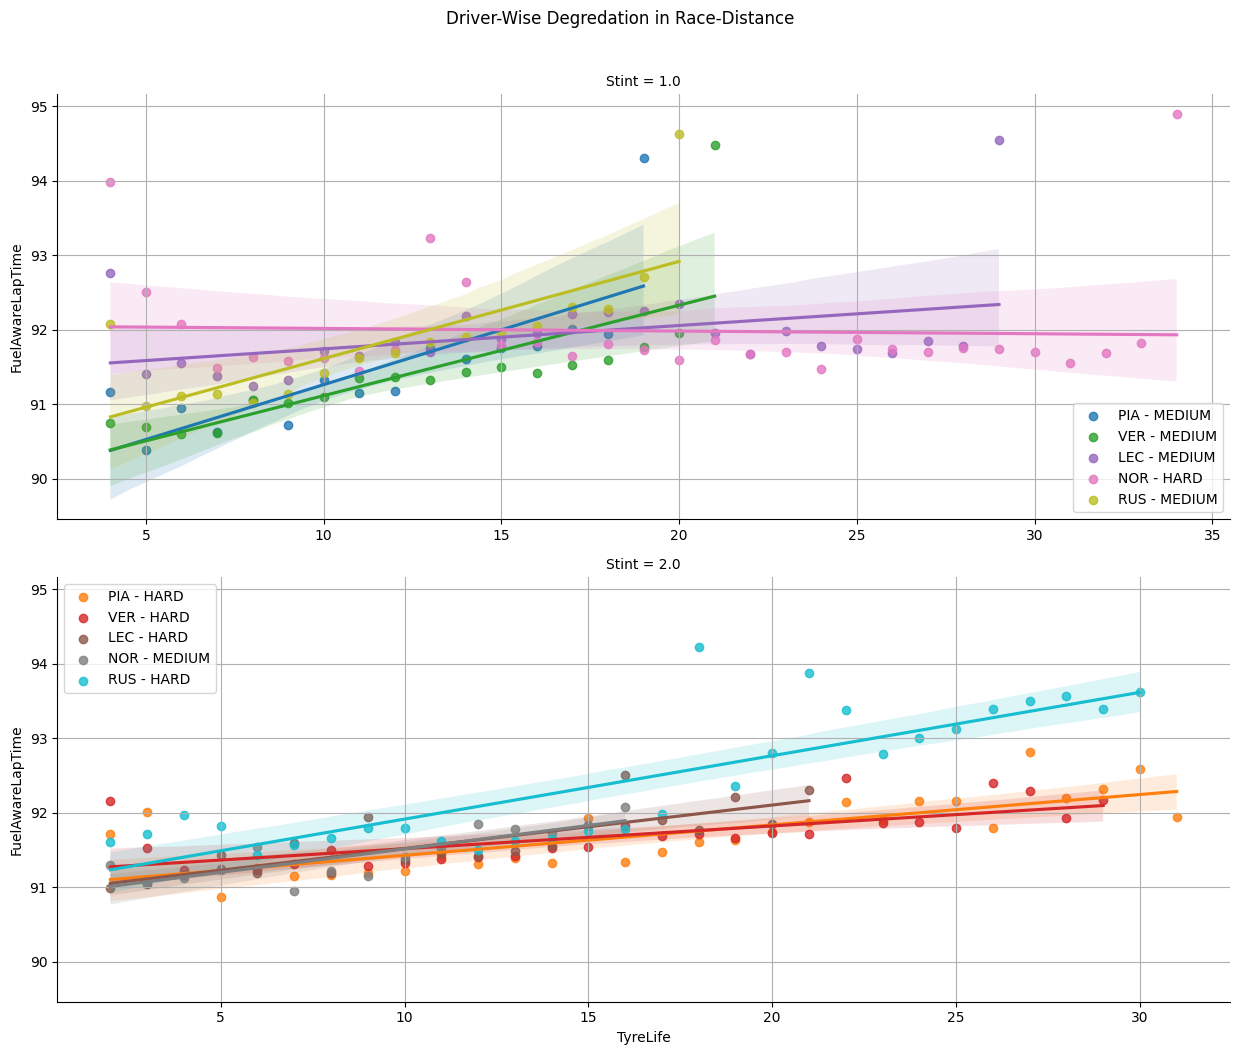

In [248]:
degredation_grid = sns.lmplot(
    data=filtered_quick_race_laps,
    x="TyreLife",
    y="FuelAwareLapTime",
    hue="DriverCompoundForStint",
    row="Stint",
    height=5,
    aspect=2.5,
    legend=False,
    facet_kws={"sharex": False}
)

for ax in degredation_grid.axes.flatten():
    ax.legend()
    ax.grid()

degredation_grid.figure.suptitle("Driver-Wise Degredation in Race-Distance", y=1.05)
plt.show()

**Inference**
- The above tyre degredation graphs are thus inline with the manually calculated coefficients of degredation.
- Further the plots for each of the stints and drivers are mostly inline with the original hypothesis as derived from the lap-level pace for each of the drivers.

## Understanding Tyre Degredation with respect to Car Setup and Track Layout
- While outright laptime is a significant driver to the tyre-degredation and hence the strategy of the race, the must still endure the race-distance with its locked race-trim.
- Thus, during a race the setup enables a car to push more in different track characteristics i.e; slow, medium and high speed sections.
- A combination such characteristics forms a sector of the track which we will use to diagnose tyre degredation further.

**Key Assumption**
- I have not accounted for the fuel burn correction over each sector as my assumption in the above lap-level analysis were already aggressive.

### Understanding the Track Layout
>Source: F1

<img src="../../assets/Saudi_Arabia_Circuit.png" alt="Image of the Jeddah Track Layout">

### Sector - 1
- As per the track layout Sector - 1 is illustrated by the `Red Path` turns 1 through 12.
- At a high-level this sector comprises of slow and medium speed corners with short straights.

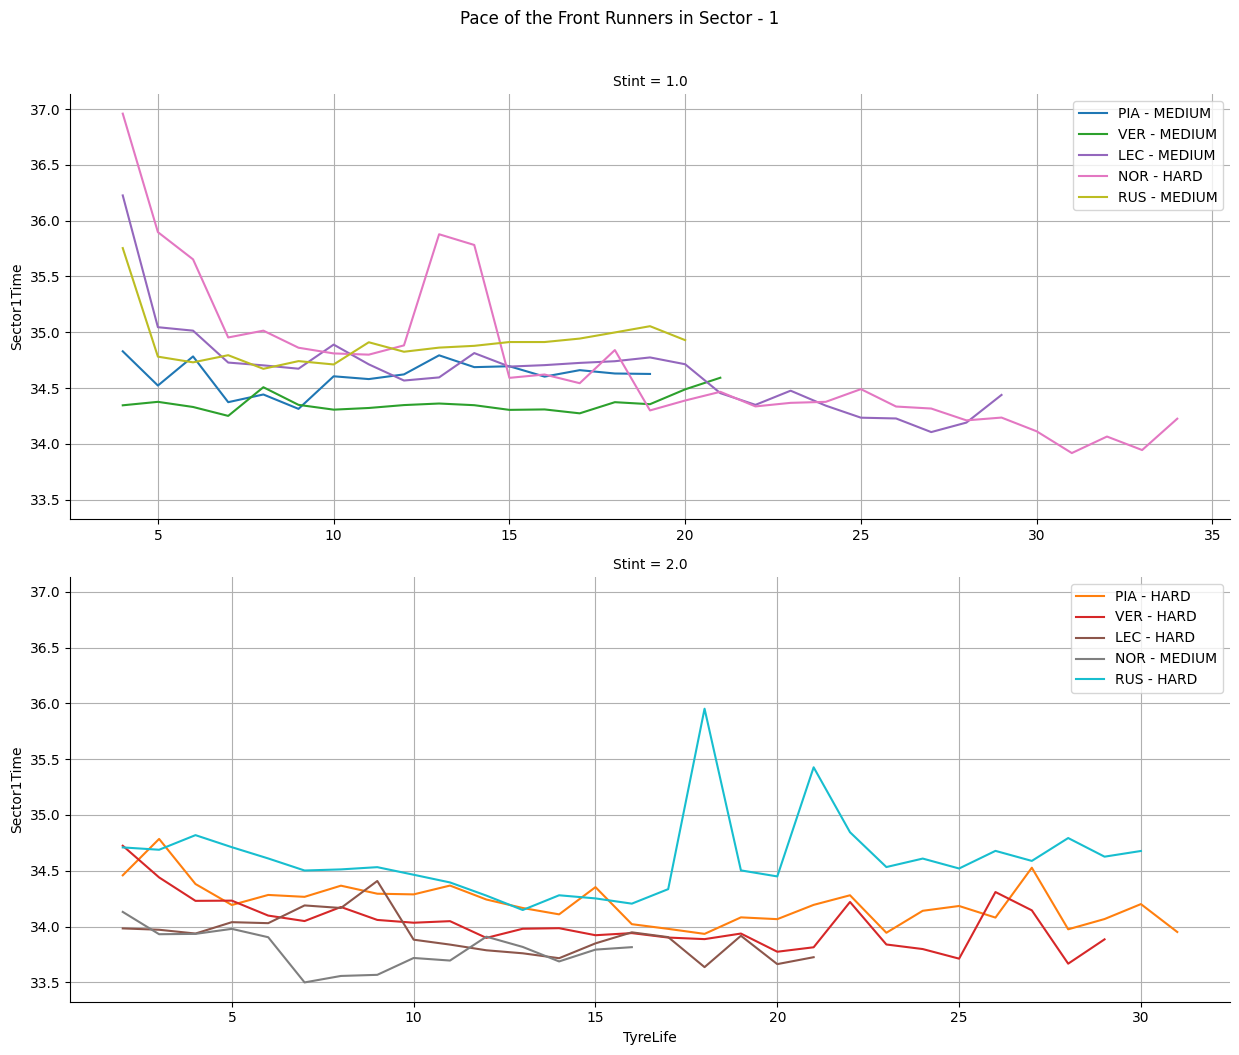

In [249]:
line_grid = sns.FacetGrid(
    data=filtered_quick_race_laps,
    row="Stint",
    hue="DriverCompoundForStint",
    height=5,
    aspect=2.5,
    sharex=False
)

line_grid.map_dataframe(
    sns.lineplot,
    x="TyreLife",
    y="Sector1Time",
)

for ax in line_grid.axes.flatten():
    ax.legend()
    ax.grid()

line_grid.figure.suptitle("Pace of the Front Runners in Sector - 1", y=1.05)
plt.show()

**Inference**

*General Notes*: 
- The performance for all the top runners in race-trim looks comparable.
- However, track evolution seems very evident in the second stint reducing the need for tyre management allowing all the drivers irrespective of the compound to push harder quickly to get into their operating windows.


- Stint - 1:
    - `Verstappen` showed amazing consistency while `Leclerc` showed amazing tyre management through the stint.
    - `Leclerc's` amazing tyre management meant he was able to lap with `Norris` who was on hards that were in within the window (ablation below).
    - `Norris` lost time between laps 12 through 15 batteling `Hamilton` for position on track (*Could have added to the tyre wear at the end in pace vs Charles*).
    - `Piastri` had the second best consistency after `Verstappen` while `Russel` had the worst pace on Mediums.
    - Plausible loss of setup performance for the Mercedes in Sector - 1: Slow to Medium Speed corners.

- Stint - 2:
    - `Piastri`, `Leclerc` and `Verstappen` all had amazing pace and consistency right from the outlap. However, in the case of `Leclerc` on the longer strategy with Hards much later in the race the out lap was perfect.
    - `Norris` was the fastest in the second stint due to his opposite strategy with much quick Mediums towards the end.
    - `Russel` also on the hards while consistent lack the pace of the front runners even with track evolution. Further, he lost time batteling `Leclerc` indicated by the spike.
    

In [250]:
# Hamilton Vs Norris - Stint 1
race_laps[(race_laps["LapNumber"] >= 11) & (race_laps["LapNumber"] <= 16) & ((race_laps["Position"] == 6.0) | (race_laps["Position"] == 7.0))]

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,SpeedFL,SpeedST,IsPersonalBest,Compound,TyreLife,FreshTyre,Team,TrackStatus,Position,Deleted
160,0 days 01:17:22.266000,NOR,4,94.088,11.0,1.0,NaN,NaN,34.799,29.494,...,306.0,313.0,True,HARD,11.0,True,McLaren,1,7.0,False
161,0 days 01:18:56.577000,NOR,4,94.311,12.0,1.0,NaN,NaN,34.882,29.515,...,297.0,319.0,False,HARD,12.0,True,McLaren,1,6.0,False
162,0 days 01:20:32.331000,NOR,4,95.754,13.0,1.0,NaN,NaN,35.878,29.550,...,298.0,329.0,False,HARD,13.0,True,McLaren,1,6.0,False
163,0 days 01:22:07.421000,NOR,4,95.090,14.0,1.0,NaN,NaN,35.782,29.647,...,310.0,327.0,False,HARD,14.0,True,McLaren,1,7.0,False
164,0 days 01:23:41.609000,NOR,4,94.188,15.0,1.0,NaN,NaN,34.591,29.752,...,296.0,306.0,False,HARD,15.0,True,McLaren,1,6.0,False
165,0 days 01:25:15.779000,NOR,4,94.170,16.0,1.0,NaN,NaN,34.621,29.739,...,296.0,306.0,False,HARD,16.0,True,McLaren,1,6.0,False
310,0 days 01:17:21.457000,HAM,44,94.456,11.0,1.0,NaN,NaN,34.828,29.649,...,296.0,316.0,False,MEDIUM,11.0,True,Ferrari,1,6.0,False
311,0 days 01:18:56.767000,HAM,44,95.310,12.0,1.0,NaN,NaN,34.871,29.816,...,310.0,315.0,False,MEDIUM,12.0,True,Ferrari,1,7.0,False
312,0 days 01:20:32.446000,HAM,44,95.679,13.0,1.0,NaN,NaN,35.138,29.701,...,311.0,316.0,False,MEDIUM,13.0,True,Ferrari,1,7.0,False
313,0 days 01:22:07.264000,HAM,44,94.818,14.0,1.0,NaN,NaN,35.001,29.753,...,296.0,313.0,False,MEDIUM,14.0,True,Ferrari,1,6.0,False


In [251]:
# Russel Vs Leclerc - Stint 2
race_laps[(race_laps["LapNumber"] >= 35) & (race_laps["LapNumber"] <= 40) & ((race_laps["Position"] == 3.0) | (race_laps["Position"] == 4.0))]

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,SpeedFL,SpeedST,IsPersonalBest,Compound,TyreLife,FreshTyre,Team,TrackStatus,Position,Deleted
134,0 days 01:55:05.033000,LEC,16,92.390,35.0,2.0,NaN,NaN,34.030,29.051,...,301.0,318.0,True,HARD,6.0,True,Ferrari,1,4.0,False
135,0 days 01:56:37.771000,LEC,16,92.738,36.0,2.0,NaN,NaN,34.189,29.044,...,302.0,314.0,False,HARD,7.0,True,Ferrari,1,4.0,False
136,0 days 01:58:10.044000,LEC,16,92.273,37.0,2.0,NaN,NaN,34.166,28.994,...,314.0,329.0,True,HARD,8.0,True,Ferrari,1,4.0,False
137,0 days 01:59:43.001000,LEC,16,92.957,38.0,2.0,NaN,NaN,34.408,29.178,...,300.0,310.0,False,HARD,9.0,True,Ferrari,1,3.0,False
138,0 days 02:01:15.325000,LEC,16,92.324,39.0,2.0,NaN,NaN,33.882,29.159,...,300.0,310.0,False,HARD,10.0,True,Ferrari,1,3.0,False
139,0 days 02:02:47.674000,LEC,16,92.349,40.0,2.0,NaN,NaN,33.838,29.071,...,299.0,311.0,False,HARD,11.0,True,Ferrari,1,3.0,False
234,0 days 01:55:03.830000,RUS,63,92.966,35.0,2.0,NaN,NaN,34.252,29.099,...,298.0,313.0,False,HARD,15.0,True,Mercedes,1,3.0,False
235,0 days 01:56:36.748000,RUS,63,92.918,36.0,2.0,NaN,NaN,34.205,29.038,...,298.0,315.0,False,HARD,16.0,True,Mercedes,1,3.0,False
236,0 days 01:58:09.817000,RUS,63,93.069,37.0,2.0,NaN,NaN,34.335,29.121,...,300.0,316.0,False,HARD,17.0,True,Mercedes,1,3.0,False
237,0 days 01:59:45.061000,RUS,63,95.244,38.0,2.0,NaN,NaN,35.952,29.415,...,299.0,314.0,False,HARD,18.0,True,Mercedes,1,4.0,False


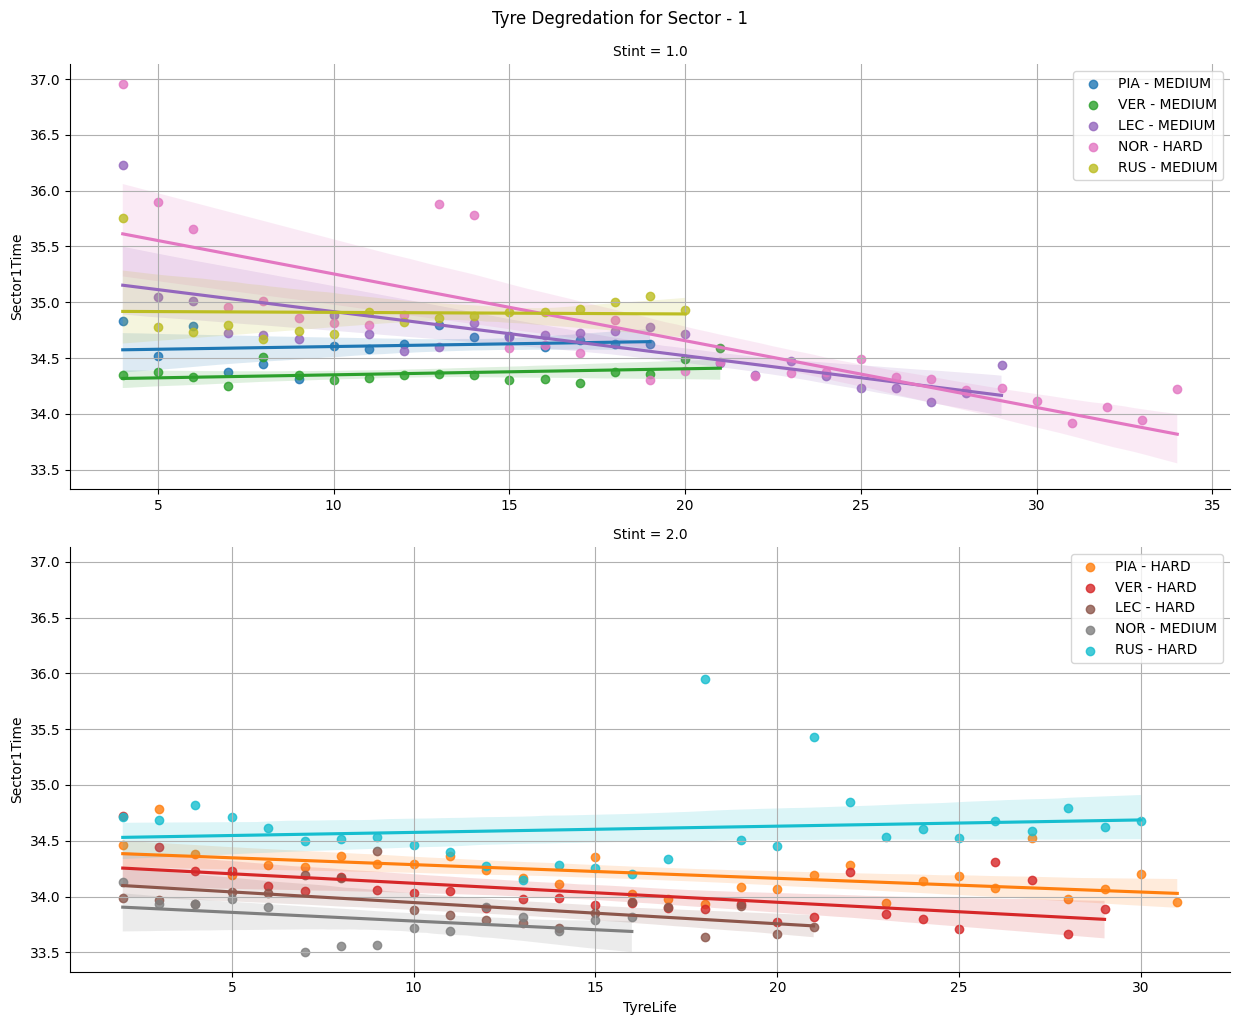

In [252]:
degredation_grid = sns.FacetGrid(
    data=filtered_quick_race_laps,
    row="Stint",
    hue="DriverCompoundForStint",
    height=5,
    aspect=2.5,
    sharex=False
)

degredation_grid.map_dataframe(
    sns.regplot,
    x="TyreLife",
    y="Sector1Time",
)

for ax in degredation_grid.axes.flatten():
    ax.legend()
    ax.grid()

degredation_grid.figure.suptitle("Tyre Degredation for Sector - 1", y=1.02)
plt.show()

In [253]:
driver_deg_coeffs = filtered_quick_race_laps.groupby(["Driver", "Stint"])[["TyreLife", "Sector1Time"]].apply(  # type: ignore
    lambda x: tyredeg_coeff(tyre_life=x.TyreLife, fuel_aware_laptime=x.Sector1Time)  # type: ignore
)
driver_deg_coeffs

Driver  Stint
LEC     1.0     -0.039485
        2.0     -0.019035
NOR     1.0     -0.059850
        2.0     -0.015554
PIA     1.0      0.004874
        2.0     -0.012271
RUS     1.0     -0.001414
        2.0      0.005582
VER     1.0      0.005411
        2.0     -0.017016
dtype: float64

### Sector - 2
- As per the track layout above sector - 2 is illustrated by the `Blue Path` turns 13 - 21.
- This section is mostly high-speed and my most favourite section of the track.
- Zooming through the corners at jaw dropping speeds between the wall is just fascinating.

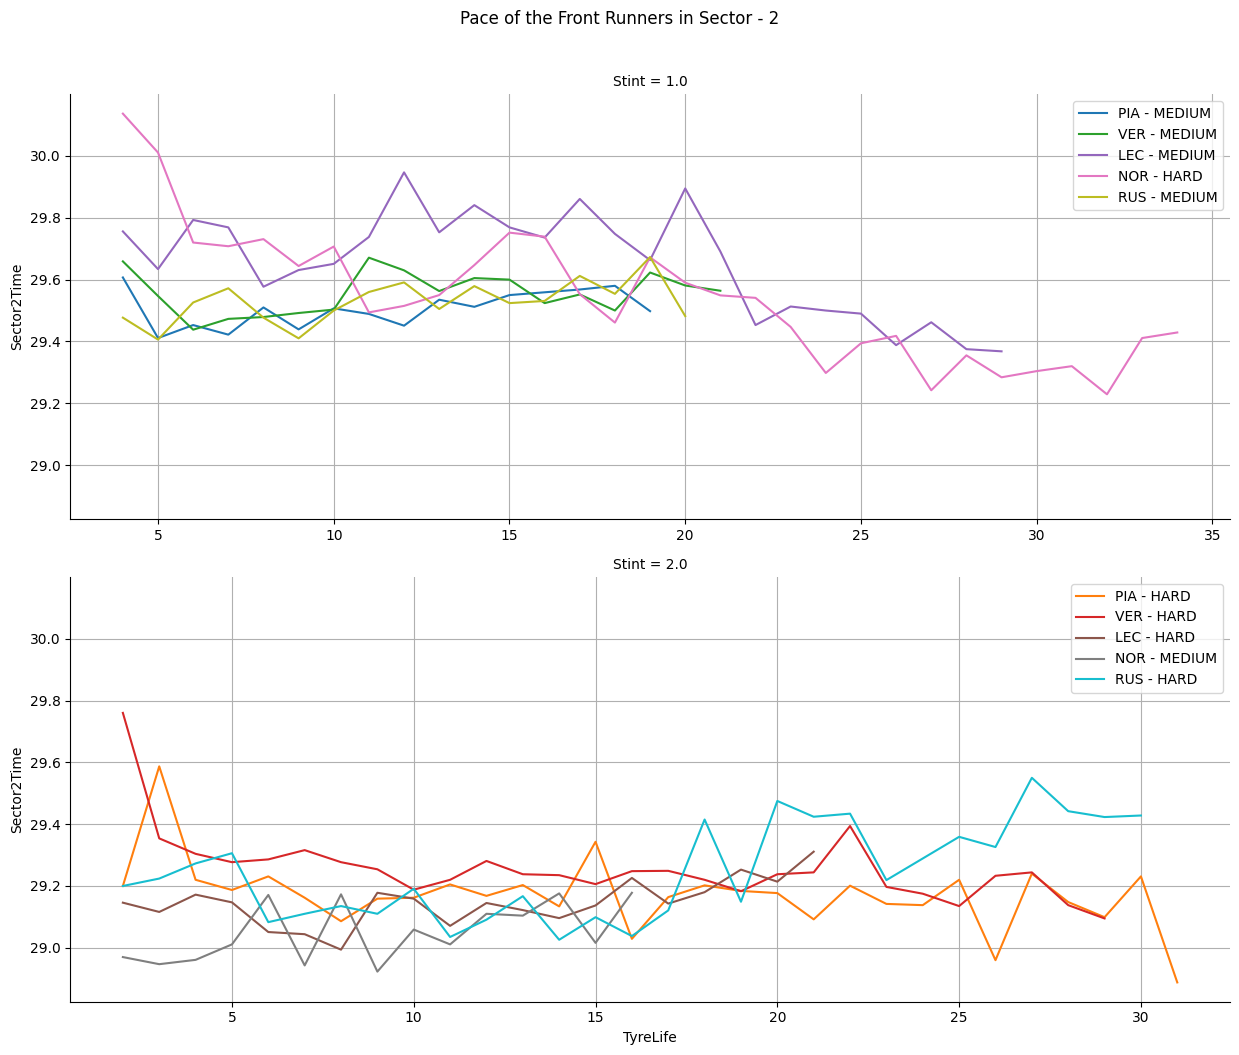

In [254]:
line_grid = sns.FacetGrid(
    data=filtered_quick_race_laps,
    row="Stint",
    hue="DriverCompoundForStint",
    height=5,
    aspect=2.5,
    sharex=False
)

line_grid.map_dataframe(
    sns.lineplot,
    x="TyreLife",
    y="Sector2Time",
    weights="SpeedI2"
)

for ax in line_grid.axes.flatten():
    ax.legend()
    ax.grid()

line_grid.figure.suptitle("Pace of the Front Runners in Sector - 2", y=1.05)
plt.show()

**Inference**
- Stint - 1
    - We can see a clear difference in the pace in the tyre-critical high-speed section that is sector 2.
    - `Norris` with the opposite strategy took his to bring the Hards into the operating window and had consistent grip throughout the rest of the stint allowing him to gain laptime.
    - `Leclerc` with the longer strategy appear to vastly manage his Mediums in the high-speed section saving tyre while also defending against low probability overtakes. This payed dividents for him later in the stint.
    - `Piastri`, `Verstappen` and `Russel` all of them fared well in the high speed section with little difference in pace and tyre degradation. However, `Piastri` was the best among the lot in managing the pace in the Mediums.
- Stint - 2
    - `Piastri` displayed execeptional performance in the sector with hard tyre gain time every lap since the intial outlaps brings the Hards into their working window.
    - `Russel` seemed to have pushed alot earlier in the stint to match the pace of `Piastri` however, he lost grip quickly and thus track position later in the stint. While `Verstappen` wasn't any impressive on the Hards.
    - Plausible weakness of the Redbull in High-Speed section.
    - `Norris` had the fastest pace for this sector in the stint however, this was massively due to the aggressive strategy. On a similar strategy `Leclerc` fired up the Hards quickly and set a good amount of laps at near quali pace for the high-speed sector makeup time given his tyre offset.

In [255]:
# Leclerc's tyre management
race_laps[
    (race_laps["Driver"] == "LEC") & 
    (race_laps["LapNumber"] > 8) & 
    (race_laps["LapNumber"] < 25)
][["LapTime", "Sector1Time", "SpeedI1", "Sector2Time", "SpeedI2", "Sector3Time", "SpeedST", "IsPersonalBest", "Position"]]

,LapTime,Sector1Time,SpeedI1,Sector2Time,SpeedI2,Sector3Time,SpeedST,IsPersonalBest,Position
108,94.099,34.673,291.0,29.631,311.0,29.795,318.0,False,4.0
109,94.419,34.889,288.0,29.651,309.0,29.879,313.0,False,4.0
110,94.293,34.712,289.0,29.738,311.0,29.843,316.0,False,4.0
111,94.425,34.567,NaN,29.947,307.0,29.911,313.0,False,4.0
112,94.217,34.595,NaN,29.753,310.0,29.869,317.0,False,4.0
113,94.641,34.813,288.0,29.841,308.0,29.987,313.0,False,4.0
114,94.276,34.692,289.0,29.769,309.0,29.815,314.0,False,4.0
115,94.293,34.705,NaN,29.736,310.0,29.852,314.0,False,4.0
116,94.476,34.725,NaN,29.861,309.0,29.890,314.0,False,4.0
117,94.439,34.740,287.0,29.748,308.0,29.951,314.0,False,4.0


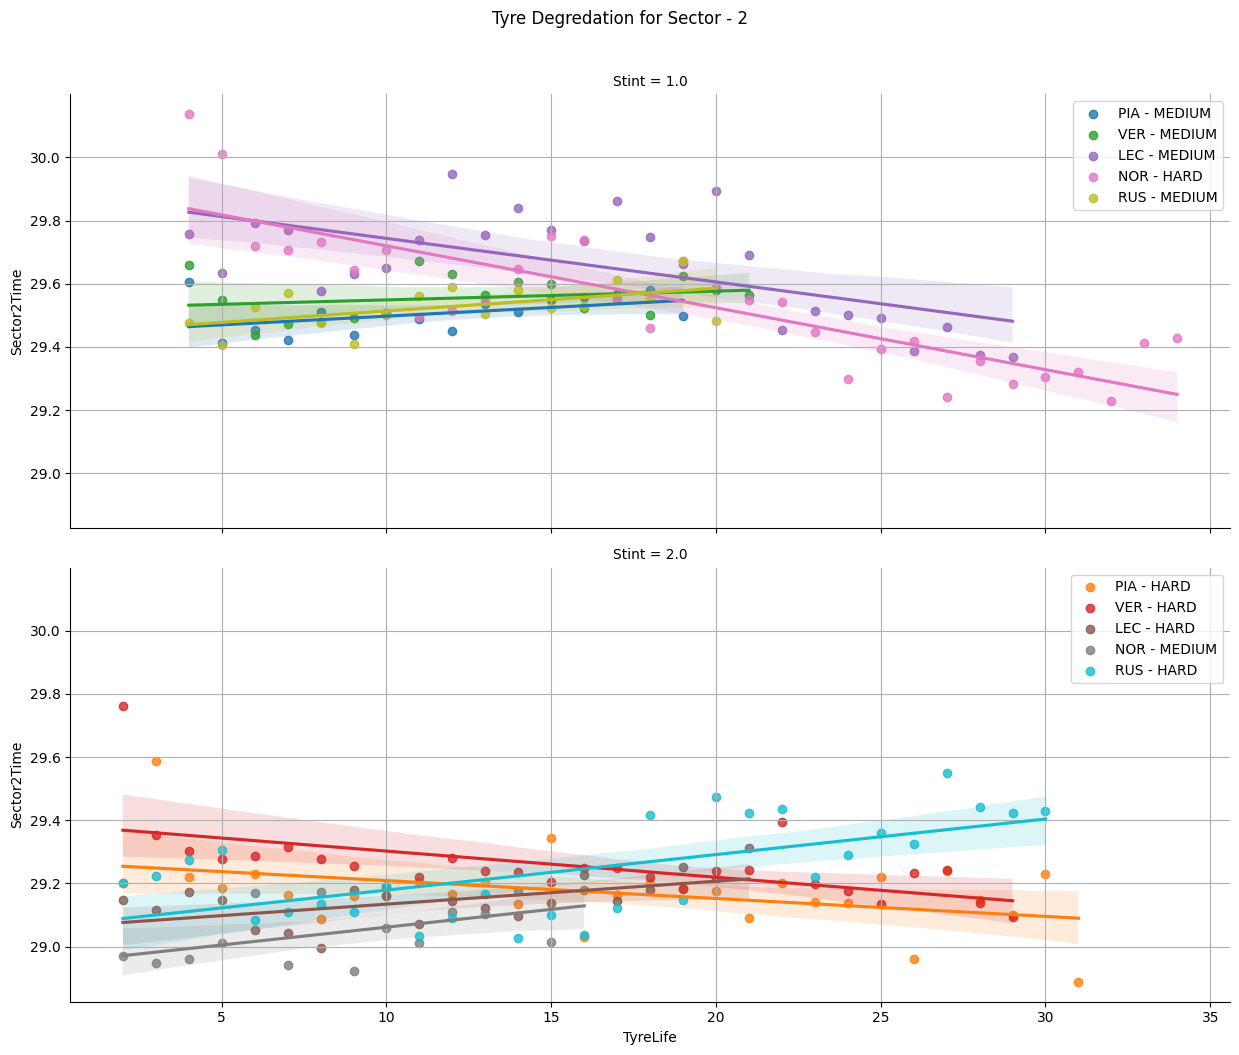

In [256]:
degredation_grid = sns.FacetGrid(
    data=filtered_quick_race_laps,
    row="Stint",
    hue="DriverCompoundForStint",
    height=5,
    aspect=2.5
)

degredation_grid.map_dataframe(
    sns.regplot,
    x="TyreLife",
    y="Sector2Time",
)

for ax in degredation_grid.axes.flatten():
    ax.legend()
    ax.grid()

degredation_grid.figure.suptitle("Tyre Degredation for Sector - 2", y=1.05)
plt.show()

In [257]:
driver_deg_coeffs = filtered_quick_race_laps.groupby(["Driver", "Stint"])[["TyreLife", "Sector2Time"]].apply(  # type: ignore
    lambda x: tyredeg_coeff(tyre_life=x.TyreLife, fuel_aware_laptime=x.Sector2Time)  # type: ignore
)
driver_deg_coeffs

Driver  Stint
LEC     1.0     -0.013798
        2.0      0.007255
NOR     1.0     -0.019594
        2.0      0.011271
PIA     1.0      0.005516
        2.0     -0.005668
RUS     1.0      0.007201
        2.0      0.011252
VER     1.0      0.002784
        2.0     -0.008270
dtype: float64

### Sector - 3
- As per the track layout above sector - 3 is illustrated by the `Yellow Path` turns 22 - 27.
- This section is mostly high-speed and long straights before a crucial breaking zone into turn 27.

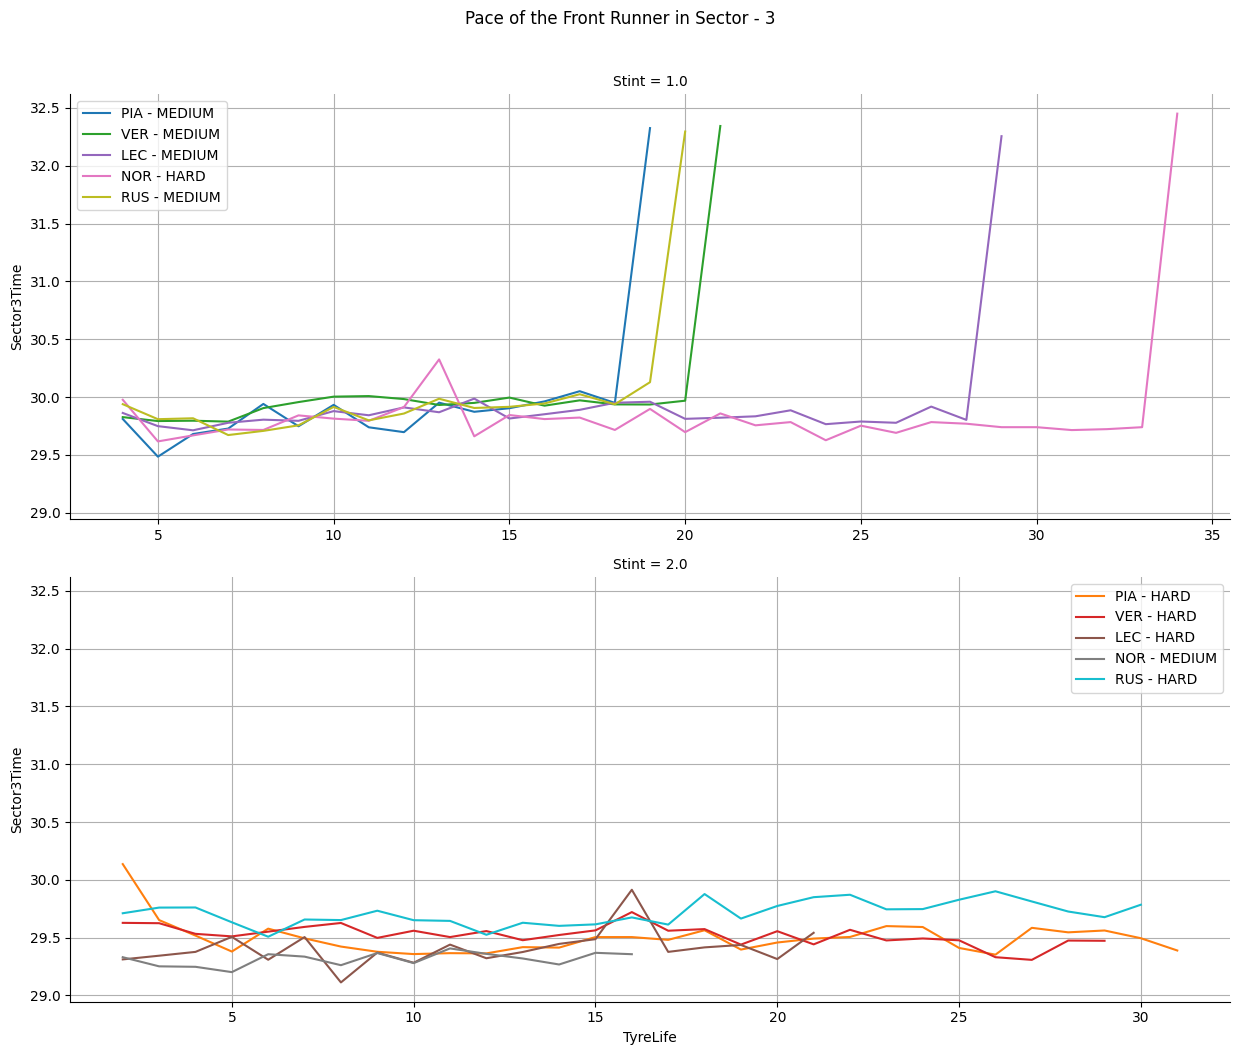

In [258]:
line_grid = sns.FacetGrid(
    data=filtered_quick_race_laps,
    row="Stint",
    hue="DriverCompoundForStint",
    height=5,
    aspect=2.5,
    sharex=False
)

line_grid.map_dataframe(
    sns.lineplot,
    x="TyreLife",
    y="Sector3Time",
    weights="SpeedST"
)

for ax in line_grid.axes.flatten():
    ax.legend()
    ax.grid()

line_grid.figure.suptitle("Pace of the Front Runner in Sector - 3", y=1.05)
plt.show()

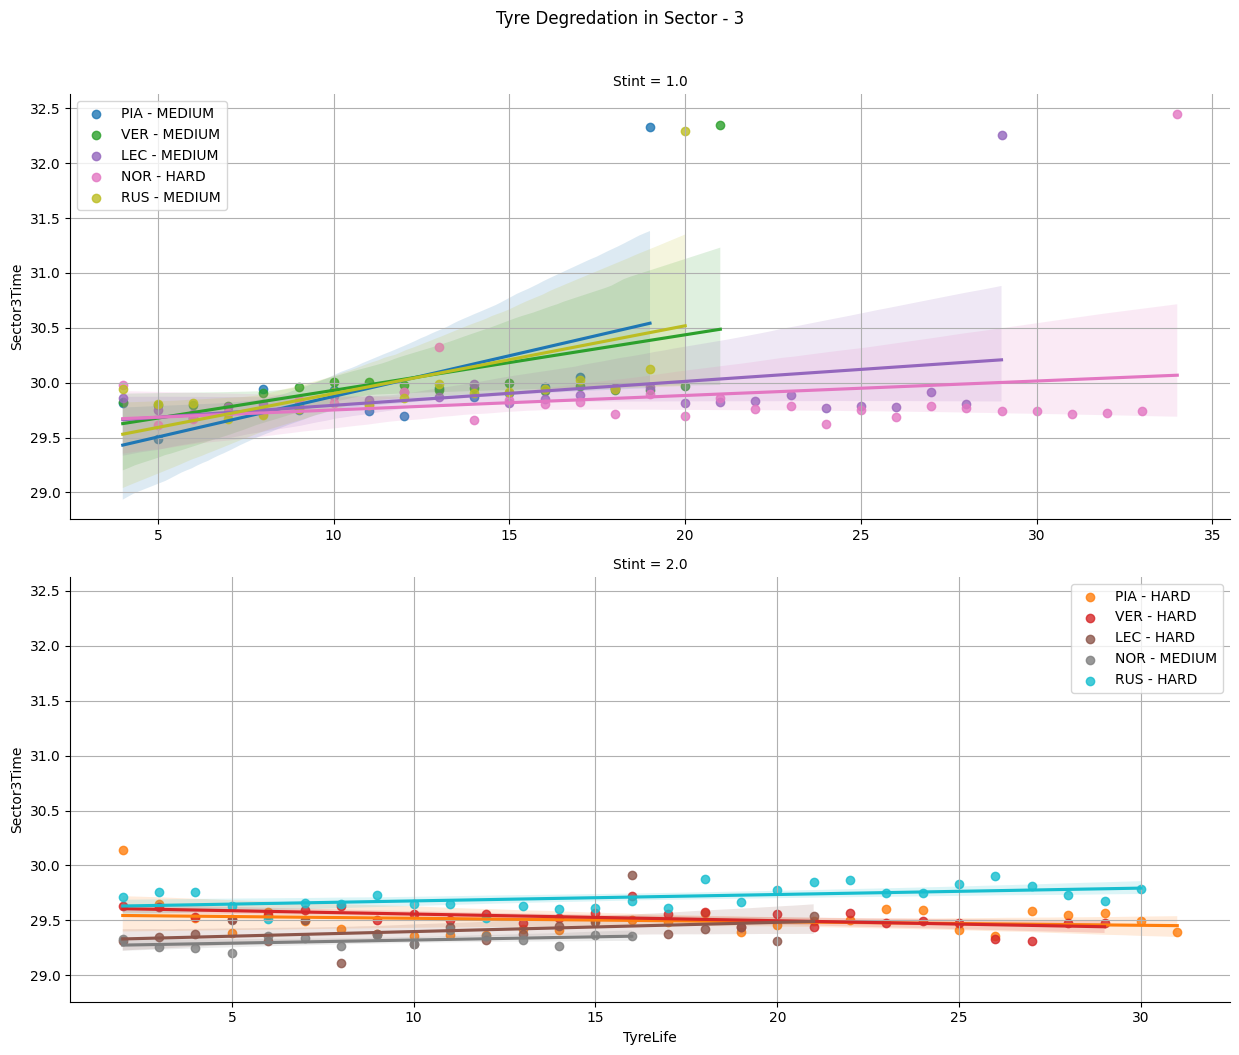

In [358]:
degredation_grid = sns.FacetGrid(
    data=filtered_quick_race_laps,
    row="Stint",
    hue="DriverCompoundForStint",
    height=5,
    aspect=2.5,
    sharex=False
)

degredation_grid.map_dataframe(
    sns.regplot,
    x="TyreLife",
    y="Sector3Time",
)

for ax in degredation_grid.axes.flatten():
    ax.legend()
    ax.grid()

degredation_grid.figure.suptitle("Tyre Degredation in Sector - 3", y=1.05)
plt.show()

**Inference**
- Unlike the other sectors with various unique corners and characteristics, this sector is a comparable for the front runners across the various manufacturers.
- This is mostly due to the simplicity of the sector and the dominance of long straights with one crucial breaking zone; the final corner.
- Thus for `Leclerc` we see the importance of saving in sector 2 through his race result, while using both sector 1 and 3 to ensure defensive positioning from key overtaking points into turn 1 and into turn 27.

## The Role of Weather in F1 and Tyres Degredation
- Alot of my understanding below is derived from this amazing [blog post](https://www.catapult.com/blog/race-strategy-f1-track-surface)

**Key Pointers**
- Track Temperature: Directly affects the tyre performance and thereby the degredation.
- Air Temperature (Ambient Temp): Directly affects the performance of the driver and the mechanical performance of the car such as Cooling, Aerodynamic Efficiency.
- Humidity: Affects the tyre degredation indirectly by interacting with the grip (frictional force) available on track.
- I have decided to omit wind-speed and direction as they are very noisy for analysis.

In [338]:
# Loading the weather data for the race session
jeddah_race_weather = jeddah_race.weather_data.copy()  # type: ignore
jeddah_race_weather

,Time,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed
0,0 days 00:00:02.318000,28.7,71.0,1006.3,False,39.4,315,1.2
1,0 days 00:01:02.315000,28.7,71.0,1006.3,False,39.4,284,1.4
2,0 days 00:02:02.314000,28.7,70.0,1006.4,False,39.4,261,0.9
3,0 days 00:03:02.328000,28.7,71.0,1006.3,False,39.4,265,0.9
4,0 days 00:04:02.323000,28.7,70.0,1006.3,False,39.2,283,1.8
...,...,...,...,...,...,...,...,...
137,0 days 02:17:02.547000,31.6,48.0,1007.3,False,36.0,0,0.3
138,0 days 02:18:02.550000,31.6,48.0,1007.2,False,35.9,153,0.4
139,0 days 02:19:02.548000,31.6,48.0,1007.2,False,36.0,267,1.1
140,0 days 02:20:02.557000,31.6,48.0,1007.2,False,36.2,275,0.5


In [339]:
# Merging the Race Data and Weather Data on uniform Session Time
weather_aware_race_df = pd.DataFrame()

# Helper function
def merge_laps_to_weather_by_driver(driver_data: pd.DataFrame, weather_aware_race_df: pd.DataFrame = weather_aware_race_df) -> pd.DataFrame:
    merged_df = pd.merge_asof(
        left=driver_data,
        right=jeddah_race_weather,
        on="Time"
    )

    weather_aware_race_df = pd.concat([weather_aware_race_df, merged_df], axis=0)
    return weather_aware_race_df

grouped_df = filtered_quick_race_laps.groupby("Driver")
for driver, driver_data in grouped_df:
    weather_aware_race_df = merge_laps_to_weather_by_driver(driver_data, weather_aware_race_df=weather_aware_race_df)

weather_aware_race_df = weather_aware_race_df.reset_index()
weather_aware_race_df

,index,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,...,LapFuelBurnt,FuelAwareLapTime,DriverCompoundForStint,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed
0,0,0 days 01:06:17.488000,LEC,16,95.845,4.0,1.0,NaN,NaN,36.226,...,2.131593,92.758948,LEC - MEDIUM,28.9,67.0,1006.7,False,38.1,158,0.4
1,1,0 days 01:07:51.916000,LEC,16,94.428,5.0,1.0,NaN,NaN,35.045,...,4.231672,91.404950,LEC - MEDIUM,28.9,67.0,1006.7,False,38.3,0,1.2
2,2,0 days 01:09:26.436000,LEC,16,94.520,6.0,1.0,NaN,NaN,35.014,...,6.333796,91.560014,LEC - MEDIUM,28.9,66.0,1006.7,False,38.2,213,1.5
3,3,0 days 01:11:00.711000,LEC,16,94.275,7.0,1.0,NaN,NaN,34.728,...,8.430472,91.377914,LEC - MEDIUM,29.0,66.0,1006.7,False,38.2,258,0.9
4,4,0 days 01:12:34.796000,LEC,16,94.085,8.0,1.0,NaN,NaN,34.703,...,10.522923,91.250688,LEC - MEDIUM,29.1,65.0,1006.7,False,38.1,280,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,41,0 days 02:11:56.488000,VER,1,92.324,46.0,2.0,NaN,NaN,33.712,...,87.176241,91.789287,VER - HARD,31.6,47.0,1007.2,False,36.3,78,1.3
226,42,0 days 02:13:29.361000,VER,1,92.873,47.0,2.0,NaN,NaN,34.309,...,89.241736,92.400252,VER - HARD,31.6,47.0,1007.3,False,36.1,183,0.7
227,43,0 days 02:15:02.058000,VER,1,92.697,48.0,2.0,NaN,NaN,34.145,...,91.303318,92.286100,VER - HARD,31.6,48.0,1007.3,False,36.2,148,1.3
228,44,0 days 02:16:34.338000,VER,1,92.280,49.0,2.0,NaN,NaN,33.667,...,93.355625,91.930669,VER - HARD,31.6,48.0,1007.2,False,36.2,0,0.5


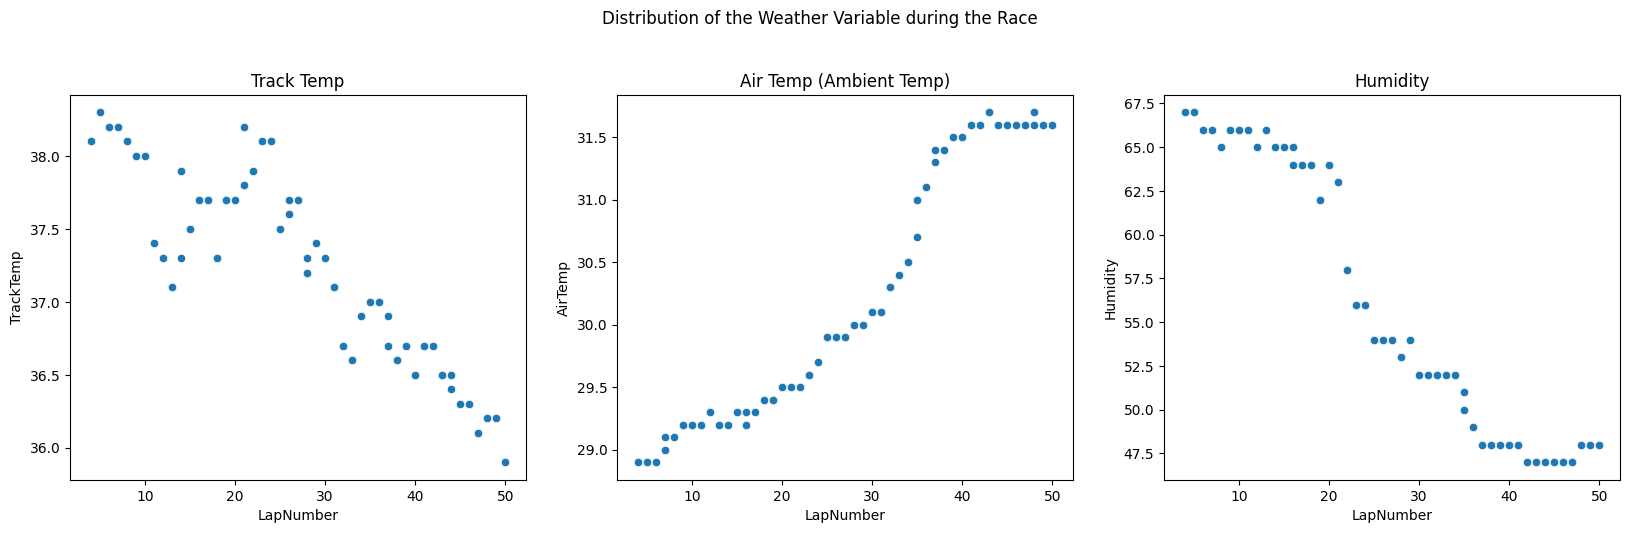

In [353]:
# Canvas for Weather Variable Grid
weather_grid, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

# Track Temp
sns.scatterplot(data=weather_aware_race_df, x="LapNumber", y="TrackTemp", ax=axes[0])
axes[0].set_title("Track Temp")

# Air Temp (Ambient Temp)
sns.scatterplot(data=weather_aware_race_df, x="LapNumber", y="AirTemp", ax=axes[1])
axes[1].set_title("Air Temp (Ambient Temp)")

# Humidity
sns.scatterplot(data=weather_aware_race_df, x="LapNumber", y="Humidity", ax=axes[2])
axes[2].set_title("Humidity")

weather_grid.suptitle("Distribution of the Weather Variable during the Race", y=1.05)
plt.show()

**Inference**
- By the above illustrated trends for the weather variables during the race session we can derive the following:
    - Track Temperature: is bi-polar in the first stint for all the drivers. The temperature falls from intial 38 degree C to 37 before rising back to 38 and then finally annelling to 36 degree C throughout the rest of the race.
    - Air Temperature: is constantly increasing through the race.
    - Humidity: is constantly decreasing through the race.
    
**Key Assumption**
- Due to the inverse nature of the trends in Humidity and Air Temperature it is safe to say their affects are mutually cancelled.

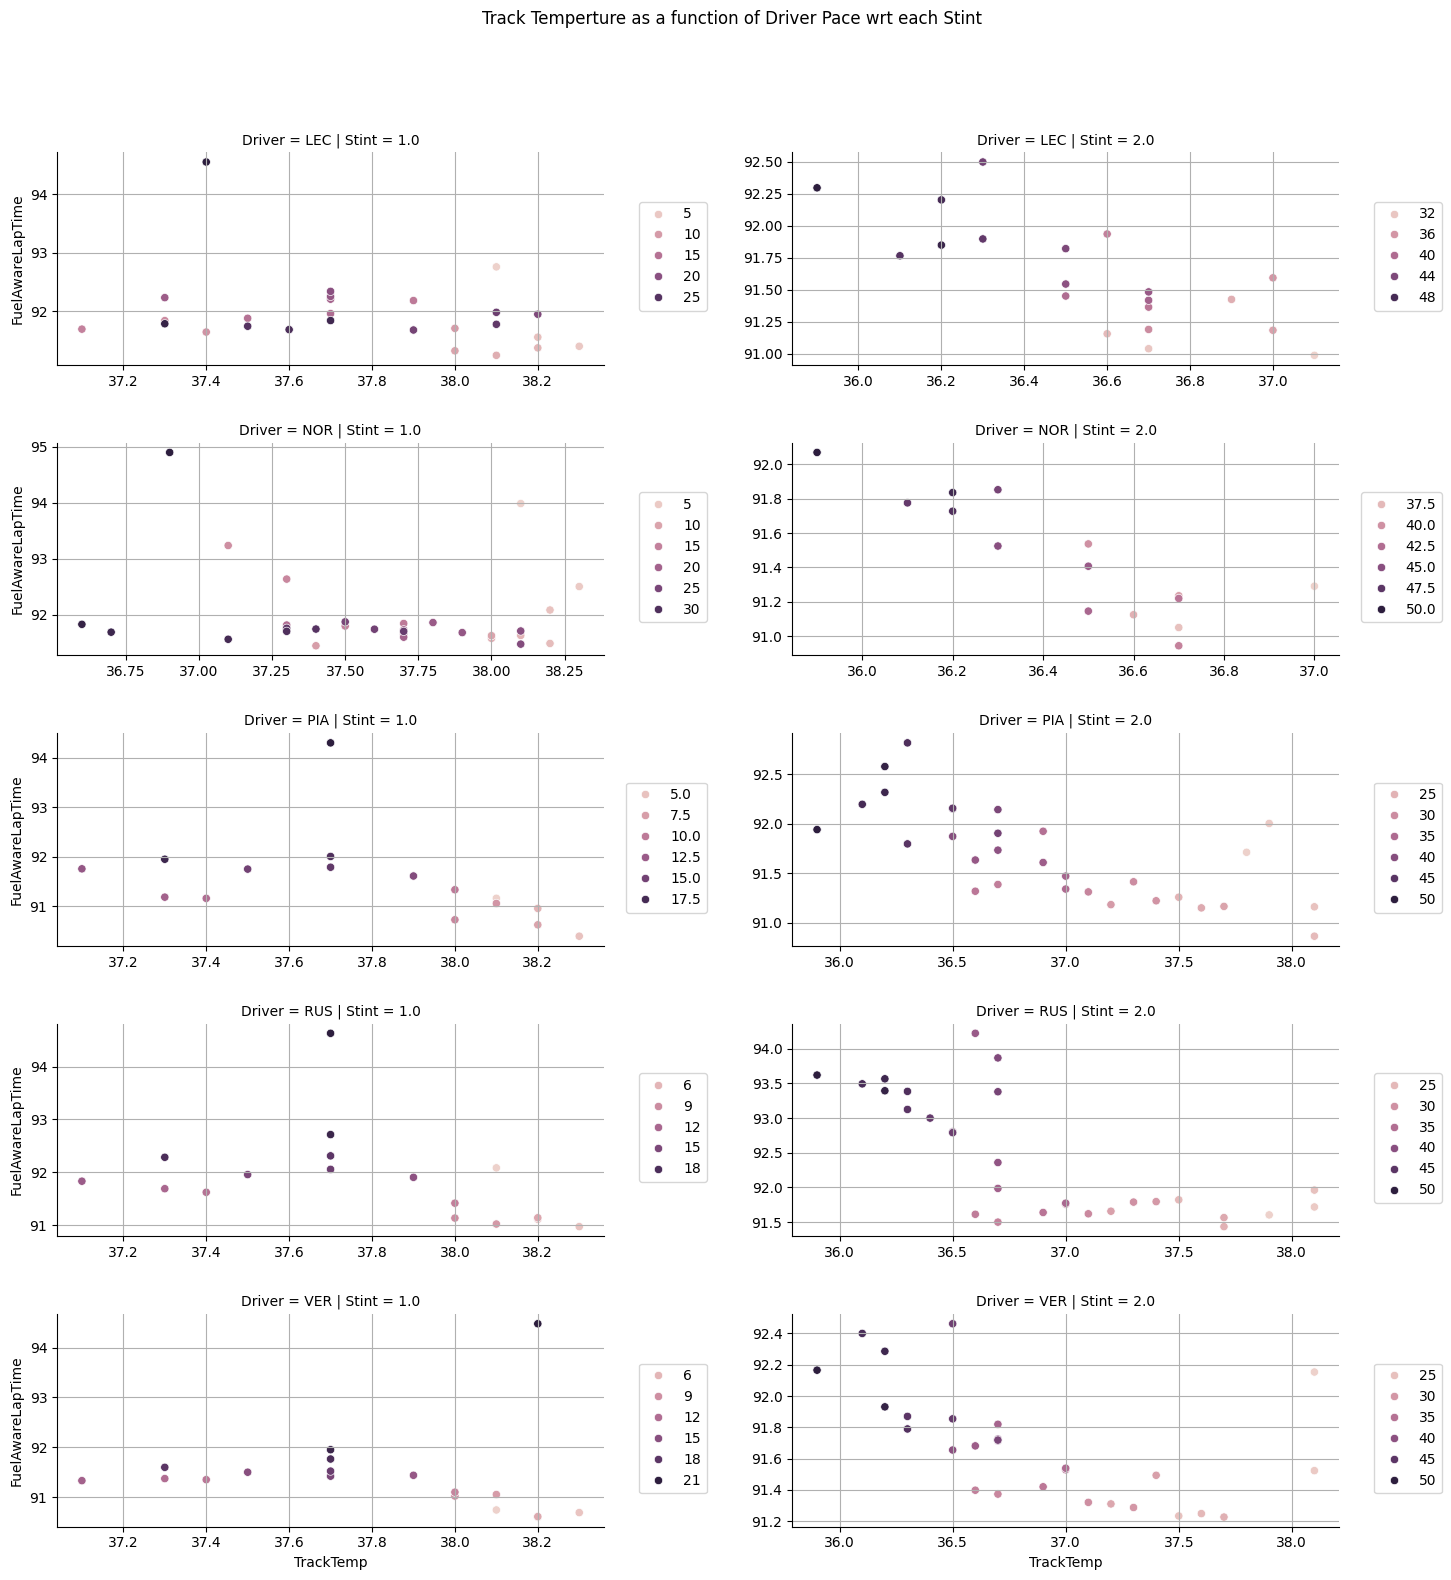

In [386]:
weather_grid = sns.FacetGrid(
    data=weather_aware_race_df,
    col="Stint",
    row="Driver",
    sharex=False,
    sharey=False,
    aspect=2.5
)

weather_grid.map_dataframe(
    sns.scatterplot,
    x="TrackTemp",
    y="FuelAwareLapTime",
    hue="LapNumber"
)

for ax in weather_grid.axes.flatten():
    ax.legend()
    sns.move_legend(obj=ax, loc="upper right", bbox_to_anchor=(1.2, 0.8))
    ax.grid()
    
weather_grid.figure.suptitle("Track Temperture as a function of Driver Pace wrt each Stint", y=1.05)
weather_grid.tight_layout(h_pad=2.5, w_pad=0.8)
plt.show()